- [read data](#read-data)
- [reshape data](#reshape-data)
- [split data](#split-data)
- [PCA](#PCA)
- [K-Means Clustering](#K-Means-Clustering)
- [KNN](#KNN)
- [Evaluation](#Evaluation)
- [AutoEncoders](#AutoEncoders)


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from collections import defaultdict
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import warnings
from sklearn.mixture import GaussianMixture

In [3]:
warnings.filterwarnings('ignore')
dataset_path = 'data'

## read data

In [5]:
images = []
labels = []

for label in range(1, 41):
    person_path = os.path.join(dataset_path, f"s{label}")
    for img_name in os.listdir(person_path):      # return list of the content of the dir like ls -l
        img_path = os.path.join(person_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        images.append(img)
        labels.append(label)   

In [6]:
images = np.array(images)
labels = np.array(labels)

print("Total images:", len(images))
print("Image shape:", images[0].shape) 

Total images: 400
Image shape: (112, 92)


## reshape data

In [8]:
images = images.reshape(-1,10304)       # Flattens 2D images into 1D vectors for input 
print("Image shape:", images.shape)
print(images)

Image shape: (400, 10304)
[[ 48  49  45 ...  47  46  46]
 [ 34  34  33 ...  37  40  33]
 [ 60  60  62 ...  32  34  34]
 ...
 [129 127 133 ...  93  93  93]
 [125 119 124 ...  36  39  40]
 [119 120 120 ...  89  94  85]]


## split data

In [10]:
images_training = []
images_testing = []
labels_training = []
labels_testing = []

for idx in range(400):
    if idx%2==0:
        images_testing.append(images[idx])
        labels_testing.append(labels[idx])
    else:
        images_training.append(images[idx])
        labels_training.append(labels[idx])

In [11]:
print("Test images:", len(images_testing))
print("Train images:", len(images_training))

print("Test labels:", len(labels_testing))
print("Train labels:", len(labels_training))

Test images: 200
Train images: 200
Test labels: 200
Train labels: 200


In [12]:
images_testing = np.array(images_testing)
images_training = np.array(images_training)

labels_testing = np.array(labels_testing)
labels_training = np.array(labels_training)
print(labels_testing)
print(labels_training)

[ 1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4  4  4  5  5  5  5
  5  6  6  6  6  6  7  7  7  7  7  8  8  8  8  8  9  9  9  9  9 10 10 10
 10 10 11 11 11 11 11 12 12 12 12 12 13 13 13 13 13 14 14 14 14 14 15 15
 15 15 15 16 16 16 16 16 17 17 17 17 17 18 18 18 18 18 19 19 19 19 19 20
 20 20 20 20 21 21 21 21 21 22 22 22 22 22 23 23 23 23 23 24 24 24 24 24
 25 25 25 25 25 26 26 26 26 26 27 27 27 27 27 28 28 28 28 28 29 29 29 29
 29 30 30 30 30 30 31 31 31 31 31 32 32 32 32 32 33 33 33 33 33 34 34 34
 34 34 35 35 35 35 35 36 36 36 36 36 37 37 37 37 37 38 38 38 38 38 39 39
 39 39 39 40 40 40 40 40]
[ 1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4  4  4  5  5  5  5
  5  6  6  6  6  6  7  7  7  7  7  8  8  8  8  8  9  9  9  9  9 10 10 10
 10 10 11 11 11 11 11 12 12 12 12 12 13 13 13 13 13 14 14 14 14 14 15 15
 15 15 15 16 16 16 16 16 17 17 17 17 17 18 18 18 18 18 19 19 19 19 19 20
 20 20 20 20 21 21 21 21 21 22 22 22 22 22 23 23 23 23 23 24 24 24 24 24
 25 25 25 25 25 26 26 26 

In [13]:
images_training = images_training / 255.0
images_testing = images_testing / 255.0

In [14]:
def euclidean_distance(x1, x2):
    return np.linalg.norm(x2 - x1, axis=1)

## PCA

In [16]:
def calc_eigen(Data_centered):
    cov_matrix = np.cov(Data_centered, rowvar=False)
    eig_vals, eig_vecs = np.linalg.eigh(cov_matrix)
    np.save("eigenvalues.npy", eig_vals)
    np.save("eigenvectors.npy", eig_vecs)
    
class PCA:
    def __init__(self):
        self.variance_threshold = None
        self.mean = None
        self.components = None
        self.explained_variance = None

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean

        # calc_eigen(X_centered)
        eig_vals = np.load('eigenvalues.npy')
        eig_vecs = np.load('eigenvectors.npy')
        
        sorted_idx = np.argsort(eig_vals)[::-1]
        eig_vals = eig_vals[sorted_idx]
        eig_vecs = eig_vecs[:, sorted_idx]

        explained_variance_ratio = eig_vals / np.sum(eig_vals)     # the ratio of each direction var
        cum_var = np.cumsum(explained_variance_ratio)        # explained_variance_ratio = [0.4, 0.3, 0.2, 0.1]  
                                                                         # cumulative_variance = [0.4, 0.7, 0.9, 1]
        
        num_components = np.argmax(cum_var >= self.variance_threshold) + 1         # returns the first index where the cumulative variance ≥ alpha.
        
        self.components = eig_vecs[:, :num_components]       # Selects all rows, col[0:num_components]  
        self.explained_variance = eig_vals[:num_components]

    def transform(self, X):
        X_centered = X - self.mean
        return np.dot(X_centered, self.components)

    def fit_transform(self, X, variance_threshold):
        self.variance_threshold = variance_threshold
        self.fit(X)
        return self.transform(X)


In [17]:
alphas = [0.8, 0.85, 0.9, 0.95]
pca = PCA()
D_pcas={}
print(f"Original shape: {images_training.shape}")

for alpha in alphas:
    D_pca = pca.fit_transform(images_training, alpha)
    D_pcas[alpha] = D_pca
    print(f"Alpha: {alpha} Reduced shape: {D_pca.shape}")


Original shape: (200, 10304)
Alpha: 0.8 Reduced shape: (200, 36)
Alpha: 0.85 Reduced shape: (200, 52)
Alpha: 0.9 Reduced shape: (200, 76)
Alpha: 0.95 Reduced shape: (200, 117)


## K-Means Clustering

In [19]:
def initialize_centroids(X, k):
    np.random.seed(0)
    indices = np.random.choice(len(X), size=k, replace=False)
    return X[indices]

def assign_clusters(X, centroids):
    clusters = defaultdict(list)
    for idx, x in enumerate(X):
        distances = np.linalg.norm(x - centroids, axis=1)
        closest = np.argmin(distances)
        clusters[closest].append(idx)
    return clusters

def update_centroids(X, clusters, k):
    new_centroids = np.zeros((k, X.shape[1]))
    for i in range(k):
        if clusters[i]:
            new_centroids[i] = np.mean(X[clusters[i]], axis=0)
        else:
            new_centroids[i] = X[np.random.randint(0, len(X))]
    return new_centroids

def kmeans(X, k, max_iters=100, tol=1e-4):
    centroids = initialize_centroids(X, k)
    for _ in range(max_iters):
        clusters = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, clusters, k)
        diff = np.linalg.norm(new_centroids - centroids)
        if diff < tol:
            break
        centroids = new_centroids
    labels = np.zeros(len(X), dtype=int)
    for cluster_idx, sample_indices in clusters.items():
        for sample_index in sample_indices:
            labels[sample_index] = cluster_idx
    return labels, centroids

def clustering_accuracy(true_labels, pred_labels, n_classes=40):
    cost_matrix = np.zeros((n_classes, n_classes), dtype=int)
    for i in range(n_classes):
        for j in range(n_classes):
            cost_matrix[i][j] = np.sum((true_labels == i + 1) & (pred_labels == j))
    row_ind, col_ind = linear_sum_assignment(-cost_matrix)
    total_correct = cost_matrix[row_ind, col_ind].sum()
    return total_correct / len(true_labels)

In [63]:
alphas = [0.8, 0.85, 0.9, 0.95]
K_values = [20, 40, 60]
results = {}

for alpha in alphas:
    reduced_data = D_pcas[alpha]
    results[alpha] = {}
    for K in K_values:
        pred_labels, centroids = kmeans(reduced_data, k=K)
        acc = clustering_accuracy(labels_training, pred_labels, n_classes=K)
        results[alpha][K] = acc
        print(f"alpha={alpha}, K={K}, accuracy={acc:.4f}")

alpha=0.8, K=20, accuracy=0.3150
alpha=0.8, K=40, accuracy=0.6750
alpha=0.8, K=60, accuracy=0.6950
alpha=0.85, K=20, accuracy=0.2950
alpha=0.85, K=40, accuracy=0.6550
alpha=0.85, K=60, accuracy=0.6850
alpha=0.9, K=20, accuracy=0.3200
alpha=0.9, K=40, accuracy=0.6700
alpha=0.9, K=60, accuracy=0.6700
alpha=0.95, K=20, accuracy=0.3050
alpha=0.95, K=40, accuracy=0.6700
alpha=0.95, K=60, accuracy=0.6500


In [65]:
print("\nAccuracy Table:")
print(" α    |   K=20   |   K=40   |   K=60  ")
print("--------------------------------------")
for alpha in alphas:
    row = f"{alpha:.2f}  |"
    for K in K_values:
        row += f"  {results[alpha][K]:.4f}  |"
    print(row)



Accuracy Table:
 α    |   K=20   |   K=40   |   K=60  
--------------------------------------
0.80  |  0.3150  |  0.6750  |  0.6950  |
0.85  |  0.2950  |  0.6550  |  0.6850  |
0.90  |  0.3200  |  0.6700  |  0.6700  |
0.95  |  0.3050  |  0.6700  |  0.6500  |


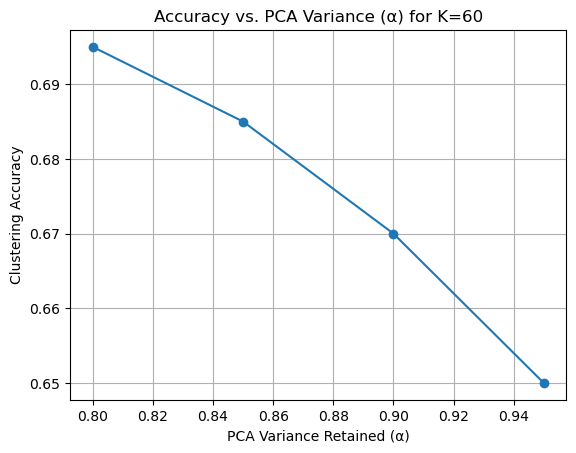

In [67]:
fixed_k = 60
alphas = [0.8, 0.85, 0.9, 0.95]
accs = [results[a][fixed_k] for a in alphas]

plt.plot(alphas, accs, marker='o')
plt.xlabel('PCA Variance Retained (α)')
plt.ylabel('Clustering Accuracy')
plt.title('Accuracy vs. PCA Variance (α) for K=60')
plt.grid(True)
plt.show()


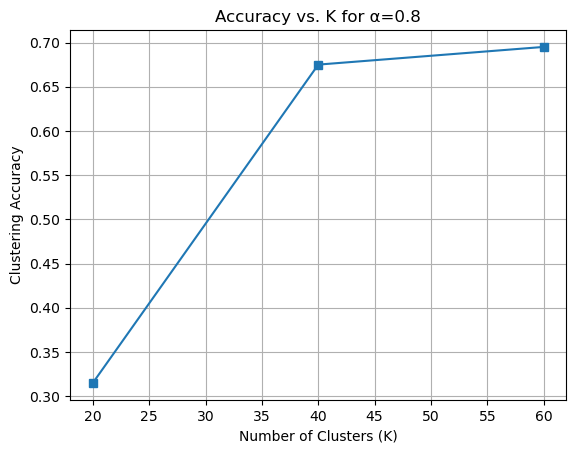

In [69]:
fixed_alpha = 0.8
ks = [20, 40, 60]
accs = [results[fixed_alpha][k] for k in ks]

plt.plot(ks, accs, marker='s')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Clustering Accuracy')
plt.title('Accuracy vs. K for α=0.8')
plt.grid(True)
plt.show()


## KNN

In [25]:
def euclidean_distance1(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))
class KNN:
    def __init__(self, images_training, labels_training, k):
        self.images_training = images_training
        self.labels_training = labels_training
        self.k = k
    
    def predict(self, imgs):
        predictions = [self._predict(img) for img in imgs]
        return np.array(predictions)
        
    def _predict(self, img):
        distances = [euclidean_distance1(img, img_train) for img_train in self.images_training]
        k_indicies = np.argsort(distances)[:self.k]             # return indicies of sorted array [4, 1, 3, 2] -> [1, 3, 2, 0]
        k_nearest_labels = [self.labels_training[i] for i in k_indicies]
        most_common = Counter(k_nearest_labels).most_common()
        most_common = np.array(most_common)
        return most_common[0][0]


In [26]:
best_alpha = 0.85
X_best = D_pcas[best_alpha]

pca = PCA()
X_test = pca.fit_transform(images_testing, best_alpha)

In [27]:
K = [5, 7, 9, 11]
results = []
for k in K:
    Knn = KNN(X_best, labels_training, k)
    y_pred = Knn.predict(X_test)
    accuracy = accuracy_score(labels_testing, y_pred)
    precision = precision_score(labels_testing, y_pred, average='macro')
    recall = recall_score(labels_testing, y_pred, average='macro')
    f1 = f1_score(labels_testing, y_pred, average='macro')
    cm = confusion_matrix(labels_testing, y_pred)
    results.append({
        'k': k,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
    })

In [28]:
for result in results:
    print(f"k = {result['k']}")
    print(f"Accuracy: {result['accuracy']:.4f}")

k = 5
Accuracy: 0.8600
k = 7
Accuracy: 0.8250
k = 9
Accuracy: 0.7850
k = 11
Accuracy: 0.7750


## Evaluation

In [30]:
best_k = 5
for result in results:
    if result['k'] == best_k:
        print(f"k = {result['k']}")
        print(f"Accuracy: {result['accuracy']:.4f}")
        print(f"Precision: {result['precision']:.4f}")
        print(f"Recall: {result['recall']:.4f}")
        print(f"F1-Score: {result['f1_score']:.4f}")
        print("Confusion Matrix:")
        print(result['confusion_matrix'])
        print("\n")

k = 5
Accuracy: 0.8600
Precision: 0.8570
Recall: 0.8600
F1-Score: 0.8466
Confusion Matrix:
[[3 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 3]]




## AutoEncoders

In [32]:
input_img = layers.Input(shape=(10304,))

encoded = layers.Dense(1024, activation='relu')(input_img)
encoded = layers.Dense(512, activation='relu')(encoded)
encoded = layers.Dense(256, activation='relu')(encoded)
encoded = layers.Dense(128, activation='relu')(encoded)

decoded = layers.Dense(256, activation='relu')(encoded)
decoded = layers.Dense(512, activation='relu')(decoded)
decoded = layers.Dense(1024, activation='relu')(decoded)
decoded = layers.Dense(10304, activation='sigmoid')(decoded)

In [33]:
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

In [34]:
autoencoder.fit(images_training, images_training,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(images_testing, images_testing))

encoder = models.Model(input_img, encoded)
X_train_encoded = encoder.predict(images_training)
X_test_encoded = encoder.predict(images_testing)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 350ms/step - loss: 0.0374 - val_loss: 0.0253
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 273ms/step - loss: 0.0256 - val_loss: 0.0245
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 271ms/step - loss: 0.0243 - val_loss: 0.0233
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step - loss: 0.0233 - val_loss: 0.0232
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step - loss: 0.0230 - val_loss: 0.0231
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step - loss: 0.0230 - val_loss: 0.0234
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 278ms/step - loss: 0.0231 - val_loss: 0.0227
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 279ms/step - loss: 0.0218 - val_loss: 0.0216
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step - loss: 0.0211 - val_loss: 0.0194
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step - loss: 0.0201 - val_loss: 0.0204
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - loss: 0.0194 - val_loss: 0.0196
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 278ms/step - loss: 0.0183 - val_lo

In [35]:
K_values = [20, 40, 60]
for K in K_values:
    pred_labels, centroids = kmeans(X_train_encoded, k=K)
    acc = clustering_accuracy(labels_training, pred_labels, n_classes=K)
    print(f"K={K} => Accuracy = {acc:.4f}")

K=20 => Accuracy = 0.2850
K=40 => Accuracy = 0.6100
K=60 => Accuracy = 0.6100


In [36]:
gmm = GaussianMixture(n_components=40, covariance_type='full', n_init=5, random_state=42)
y_pred_auto = gmm.fit_predict(X_train_encoded)

gmm = GaussianMixture(n_components=40, covariance_type='full', n_init=5, random_state=42)
y_pred_pca = gmm.fit_predict(D_pcas[fixed_alpha])

acc_gmm = clustering_accuracy(labels_training, y_pred_auto)
print("Autoencoder + GMM Accuracy:", round(acc_gmm, 4))

acc_gmm = clustering_accuracy(labels_training, y_pred_pca)
print("PCA + GMM Accuracy:", round(acc_gmm, 4))


Autoencoder + GMM Accuracy: 0.635
PCA + GMM Accuracy: 0.78
